# Optical RL-Gym

## Using heuristics to solve the RMSA environment

Before running this notebook make sure to have installed `pandas` and `stable_baselines3` in your Python environment, in addition to the other dependencies of this library.

### Imports

In [1]:
# general imports

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# environment import
import gym
from stable_baselines3.common.monitor import Monitor

from optical_rl_gym.utils import evaluate_heuristic, random_policy

### Setting up the environment

In [2]:
# loading the topology binary file containing the graph and the k-shortest paths
# if you want to generate your own binary topology file, check examples/create_topology_rmsa.py
topology_name = 'nsfnet_chen_eon'
k_paths = 5
with open(f'../topologies/{topology_name}_{k_paths}-paths.h5', 'rb') as f:
    topology = pickle.load(f)

# node probabilities from https://github.com/xiaoliangchenUCD/DeepRMSA/blob/6708e9a023df1ec05bfdc77804b6829e33cacfe4/Deep_RMSA_A3C.py#L77
node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
       0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
       0.07607608, 0.12012012, 0.01901902, 0.16916917])

number_episodes = 500
monitor_info_keywords=('episode_service_blocking_rate','episode_bit_rate_blocking_rate')
plotting_average_window = 50

# mean_service_holding_time=7.5,
env_args = dict(topology=topology, seed=10, 
                allow_rejection=False, # the agent cannot proactively reject a request
                load=55,
                num_spectrum_resources=64,
                episode_length=50, node_request_probabilities=node_request_probabilities)

# Create log dir
log_dir = "./tmp/rmsa-heu/"
os.makedirs(log_dir, exist_ok=True)

### Running the environment for a random policy

In [3]:
env = gym.make('RMSA-v0', **env_args)

# logs will be saved in log_dir/sp_ff.monitor.csv
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
env_rnd = Monitor(env, log_dir + 'rnd', info_keywords=monitor_info_keywords)
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# run the heuristic for a number of episodes
mean_reward_rnd, std_reward_rnd = evaluate_heuristic(env_rnd, random_policy, n_eval_episodes=number_episodes)
print('Rnd:'.ljust(8), f'{mean_reward_rnd:.4f}  {std_reward_rnd:>7.4f}')
print('Bit rate blocking:', (env_rnd.episode_bit_rate_requested - env_rnd.episode_bit_rate_provisioned) / env_rnd.episode_bit_rate_requested)
print('Request blocking:', (env_rnd.episode_services_processed - env_rnd.episode_services_accepted) / env_rnd.episode_services_processed)

Rnd:     13.7740   3.0422
Bit rate blocking: 0.7799593771157752
Request blocking: 0.74


### Running the environment for Shortest-Path First-Fit (SP-FF) heuristic

This heuristic only accepts the shortest path for, e.g., latency-critical applications.

In [4]:
# importing the heuristic algorithm
from optical_rl_gym.envs.rmsa_env import shortest_path_first_fit

env = gym.make('RMSA-v0', **env_args)

# logs will be saved in log_dir/sp_ff.monitor.csv
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
env_sp_ff = Monitor(env, log_dir + 'sp_ff', info_keywords=monitor_info_keywords)
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# run the heuristic for a number of episodes
mean_reward_sp_ff, std_reward_sp_ff = evaluate_heuristic(env_sp_ff, shortest_path_first_fit, n_eval_episodes=number_episodes)
print('SP-FF:'.ljust(8), f'{mean_reward_sp_ff:.4f}  {std_reward_sp_ff:>7.4f}')
print('Bit rate blocking:', (env_sp_ff.episode_bit_rate_requested - env_sp_ff.episode_bit_rate_provisioned) / env_sp_ff.episode_bit_rate_requested)
print('Request blocking:', (env_sp_ff.episode_services_processed - env_sp_ff.episode_services_accepted) / env_sp_ff.episode_services_processed)

SP-FF:   42.2980   3.5459
Bit rate blocking: 0.24542992552471227
Request blocking: 0.2


### Running the environment for Shortest-Available-Path First-Fit (llp-FF) heuristic

This heuristic is also known as *k*-shortest-paths first-fit.

In [5]:
# importing the heuristic algorithm
from optical_rl_gym.envs.rmsa_env import shortest_available_path_first_fit

env = gym.make('RMSA-v0', **env_args)

# logs will be saved in log_dir/sp_ff.monitor.csv
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
env_sap_ff = Monitor(env, log_dir + 'sap_ff', info_keywords=monitor_info_keywords)
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# run the heuristic for a number of episodes
mean_reward_sap_ff, std_reward_sap_ff = evaluate_heuristic(env_sap_ff, shortest_available_path_first_fit, n_eval_episodes=number_episodes)
print('SAP-FF:'.ljust(8), f'{mean_reward_sap_ff:.4f}  {std_reward_sap_ff:>7.4f}')
print('Bit rate blocking:', (env_sap_ff.episode_bit_rate_requested - env_sap_ff.episode_bit_rate_provisioned) / env_sap_ff.episode_bit_rate_requested)
print('Request blocking:', (env_sap_ff.episode_services_processed - env_sap_ff.episode_services_accepted) / env_sap_ff.episode_services_processed)

SAP-FF:  46.1280   2.6374
Bit rate blocking: 0.08666215301286391
Request blocking: 0.08


### Running the environment for Least-Loaded-Path First-Fit (LLP-FF) heuristic

This heuristic does load balancing by selecting the of the *k* shortest-paths that has the least number of slots occupied.

In [6]:
# importing the heuristic algorithm
from optical_rl_gym.envs.rmsa_env import least_loaded_path_first_fit

env = gym.make('RMSA-v0', **env_args)

# logs will be saved in log_dir/sp_ff.monitor.csv
# in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
env_llp_ff = Monitor(env, log_dir + 'llp_ff', info_keywords=monitor_info_keywords)
# for more information about the monitor, check https://stable-baselines.readthedocs.io/en/master/_modules/stable_baselines/bench/monitor.html#Monitor

# run the heuristic for a number of episodes
mean_reward_llp_ff, std_reward_llp_ff = evaluate_heuristic(env_llp_ff, least_loaded_path_first_fit, n_eval_episodes=number_episodes)
print('LLP-FF:'.ljust(8), f'{mean_reward_llp_ff:.4f}  {std_reward_llp_ff:>7.4f}')
print('Bit rate blocking:', (env_llp_ff.episode_bit_rate_requested - env_llp_ff.episode_bit_rate_provisioned) / env_llp_ff.episode_bit_rate_requested)
print('Request blocking:', (env_llp_ff.episode_services_processed - env_llp_ff.episode_services_accepted) / env_llp_ff.episode_services_processed)

LLP-FF:  46.4160   2.6801
Bit rate blocking: 0.06127285037237644
Request blocking: 0.04


## Plotting the results

### Reading the data from the environment monitor

In [7]:
rnd_data = pd.read_csv(log_dir + 'rnd.monitor.csv', skiprows=1)
sp_ff_data = pd.read_csv(log_dir + 'sp_ff.monitor.csv', skiprows=1)
sap_ff_data = pd.read_csv(log_dir + 'sap_ff.monitor.csv', skiprows=1)
llp_ff_data = pd.read_csv(log_dir + 'llp_ff.monitor.csv', skiprows=1)
rnd_data.describe()

,r,l,t,episode_service_blocking_rate,episode_bit_rate_blocking_rate
count,500.000000,500.0,500.000000,500.000000,500.000000
mean,13.774000,50.0,8.500041,0.724520,0.744476
std,3.045237,0.0,4.889987,0.060905,0.061870
min,5.000000,50.0,0.046697,0.520000,0.539884
25%,12.000000,50.0,4.218741,0.680000,0.704434
50%,14.000000,50.0,8.503431,0.720000,0.749790
75%,16.000000,50.0,12.717457,0.760000,0.787257
max,24.000000,50.0,16.962707,0.900000,0.910423


### Generating plots

We use `np.convolve` to smoothen the curve having the `plotting_average_window` as the parameter.

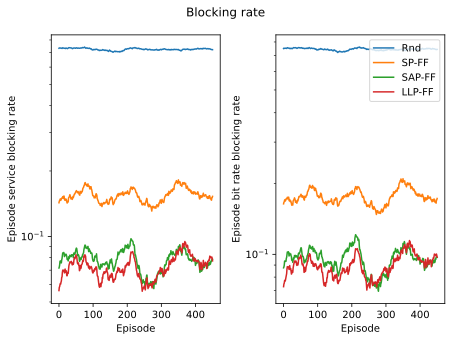

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Blocking rate')

ax1.semilogy(np.convolve(rnd_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax1.semilogy(np.convolve(sp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax1.semilogy(np.convolve(sap_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax1.semilogy(np.convolve(llp_ff_data['episode_service_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')

ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode service blocking rate')

ax2.semilogy(np.convolve(rnd_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='Rnd')
ax2.semilogy(np.convolve(sp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SP-FF')
ax2.semilogy(np.convolve(sap_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='SAP-FF')
ax2.semilogy(np.convolve(llp_ff_data['episode_bit_rate_blocking_rate'], np.ones(plotting_average_window)/plotting_average_window, mode='valid'), label='LLP-FF')

ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode bit rate blocking rate')

plt.legend(loc=1)
plt.tight_layout()
plt.savefig(log_dir + "blocking.pdf")
plt.savefig(log_dir + "blocking.svg")
plt.show()